In [1]:
import pandas as pd
import numpy as np
import os
import math

import pomegranate as pom

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/6A_B5/"
data_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/wh17/"

spots_path = f"{data_dir}/spots.csv"
df = pd.read_csv(spots_path, skiprows=[1, 2, 3])

print(df.shape)
df.head()

(214898, 46)


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_X0,ELLIPSE_Y0,ELLIPSE_MAJOR,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY
0,ID2048,2048,0.0,0.881755,378.892277,1275.882220,0.0,0.0,0,9.373108,...,-0.025051,0.004838,12.159079,7.357488,-0.881462,1.652613,276.005119,65.098372,0.818440,0.967213
1,ID2049,2049,1.0,0.881288,2546.617345,595.827218,0.0,0.0,0,9.388981,...,0.010721,-0.032076,10.979096,8.101009,-0.507153,1.355275,276.940729,63.295469,0.868663,0.970492
2,ID2050,2050,2.0,0.880880,1413.473149,2276.756729,0.0,0.0,0,10.267726,...,-0.034062,0.011548,12.985505,8.209648,-0.873679,1.581737,331.206143,70.634471,0.834209,0.964578
3,ID2051,2051,3.0,0.880714,2840.339787,350.596714,0.0,0.0,0,8.714505,...,-0.000233,-0.016225,10.847612,7.054313,0.100432,1.537728,238.580696,63.697626,0.738922,0.937500
4,ID2052,2052,4.0,0.880067,2321.230790,1677.189471,0.0,0.0,0,11.210600,...,-0.027172,-0.016732,13.826768,9.164189,0.221983,1.508783,394.827661,75.113433,0.879391,0.979118


# Simple Preparation

In [3]:
def prepare_tracks(df, minutes_per_frame=25):
    """A function to add time and step variables to the dataframe """
    df = df.sort_values(by=['TRACK_ID', 'FRAME'])
    df.loc[:, 'STEP'] =  df.groupby(['TRACK_ID']).cumcount()
    df['Time'] = (df['FRAME'] * minutes_per_frame) / 60
    return df


def frame_to_hour(frame, df=df, minutes_per_frame=25):
    """A utility function to convert quickly between hours and frames"""
    return df.loc[df['FRAME'] == frame, 'Time'].drop_duplicates().values[0]


df = prepare_tracks(df)
print(df.shape)

(214898, 48)


In [4]:
def col_renamer(df, str_match, new_name):
    """A function to rename columns with a substrig substitution """
    old_names = [x for x in df.columns if str_match in x]
    new_names = [x.replace(str_match, new_name) for x in old_names]
    rename_dict = dict(zip(old_names, new_names))
    
    df = df.rename(columns=rename_dict)
    return df

# rename some columns
df = col_renamer(df, 'CH1', 'RED')
df = col_renamer(df, 'CH2', 'GREEN')
df = col_renamer(df, 'CH3', 'BLUE')
df.columns

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED',
       'MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED',
       'STD_INTENSITY_RED', 'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN',
       'MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN',
       'STD_INTENSITY_GREEN', 'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE',
       'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE',
       'STD_INTENSITY_BLUE', 'CONTRAST_RED', 'SNR_RED', 'CONTRAST_GREEN',
       'SNR_GREEN', 'CONTRAST_BLUE', 'SNR_BLUE', 'ELLIPSE_X0', 'ELLIPSE_Y0',
       'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'STEP', 'Time'],
      dtype='object')

In [5]:
def normalize_tracks(df, col_list, w=7):
    """A function to normalize tracks """
    for col, max_norm  in col_list.items():
        # rolling mean
        mean_colname = f"mean_{col}"
        df[mean_colname] = df.groupby('TRACK_ID')[col].transform(lambda s: s.rolling(w).mean())
        # replace the first values not averaged
        df[mean_colname] = np.where(df['STEP'] < w,  df[col], df[mean_colname])
        df[mean_colname] = df[mean_colname] / df.groupby('TRACK_ID')[mean_colname].transform(np.max)
        
        
        # rolling mean
        std_colname = f"std_{col}"
        df[std_colname] = df.groupby('TRACK_ID')[col].transform(lambda s: s.rolling(w).std())
        # replace the first values not averaged
        df[std_colname] = np.where(df['STEP'] < w,  0, df[std_colname])
        df[std_colname] = df[std_colname] / df[col]
    return df

col_list = {
    'MEAN_INTENSITY_RED' : True,
    'MEAN_INTENSITY_GREEN' : True,
    'MEAN_INTENSITY_BLUE' : True,
}

WINDOW = 6
df = normalize_tracks(df, col_list, w=WINDOW)
df.head()

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,CIRCULARITY,SOLIDITY,STEP,Time,mean_MEAN_INTENSITY_RED,std_MEAN_INTENSITY_RED,mean_MEAN_INTENSITY_GREEN,std_MEAN_INTENSITY_GREEN,mean_MEAN_INTENSITY_BLUE,std_MEAN_INTENSITY_BLUE
0,ID2048,2048,0.0,0.881755,378.892277,1275.882220,0.0,0.000000,0,9.373108,...,0.818440,0.967213,0,0.000000,0.438156,0.0,0.607753,0.0,0.638965,0.0
1281,ID3281,3281,0.0,0.840964,374.015596,1284.786984,0.0,1350.157432,1,8.524473,...,0.795440,0.960630,1,0.416667,0.757467,0.0,0.736921,0.0,0.742110,0.0
2194,ID4242,4242,0.0,0.856497,370.306430,1287.541590,0.0,2700.314864,2,8.645886,...,0.809289,0.965385,2,0.833333,0.866712,0.0,0.728245,0.0,0.722111,0.0
3640,ID5618,5618,0.0,0.809693,368.478977,1288.211695,0.0,4050.472296,3,7.301282,...,0.777705,0.942105,3,1.250000,0.833132,0.0,1.000000,0.0,1.000000,0.0
4859,ID6859,6859,0.0,0.790261,372.355090,1287.768018,0.0,5400.629728,4,7.889433,...,0.760898,0.954338,4,1.666667,0.738722,0.0,0.814599,0.0,0.802937,0.0


# Diagnostics

In [6]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 7, 9
# fig, axs = plt.subplots(4)

# # some grouped stats
# grped = df.groupby('Time').agg(
#     sum_cells = ('TRACK_ID', 'count'),
#     mean_area = ('AREA', np.mean),
#     mean_circ = ('CIRCULARITY', np.mean),
#     mean_blue = ('MEAN_INTENSITY_BLUE', np.mean)
# ).reset_index()

# # cell counts
# sns.lineplot(data=grped,
#              x='Time', 
#              y='sum_cells',
#              color='k',
#              lw=2,
#              ax=axs[0])


# axs[0].set_ylabel("N Cells")
# axs[0].set_title("Number of Detected Cells")
# axs[0].set_xlabel("Time (hrs)")

# # mean area
# sns.lineplot(data=grped,
#              x='Time', 
#              y='mean_area',
#              color='k',
#              lw=2,
#              ax=axs[1])

# axs[1].set_ylabel("Average Area ($\mu m^2$)")
# axs[1].set_title("Average Nucleus Size")
# axs[1].set_xlabel("Time (hrs)")


# # mean circularity
# sns.lineplot(data=grped,
#              x='Time', 
#              y='mean_blue',
#              color='b',
#              lw=2,
#              ax=axs[2])

# axs[2].set_ylabel("Normalized Intensity")
# axs[2].set_title("Average H2B Intensity")
# axs[2].set_xlabel("Time (hrs)")

# # add the normalized mean signals
# sns.lineplot(data=df,
#              x='Time', 
#              y='mean_MEAN_INTENSITY_RED',
#              err_style="bars", ci=68,
#              color='r',
#              lw=1,
#              alpha=0.5, 
#              ax=axs[3],
#              label='Mean mCherry')

# sns.lineplot(data=df,
#              x='Time', 
#              y='mean_MEAN_INTENSITY_GREEN',
#              err_style="bars", ci=68,
#              color='g',
#              lw=1,
#              alpha=0.5,
#              ax=axs[3],
#              label='Mean mVenus')


# axs[3].legend()
# axs[3].set_ylabel("Normalized Intensity")
# axs[3].set_title("Normalized mCherry/mVenus Signals")
# axs[3].set_xlabel("Time (hrs)")

# fig.tight_layout()

# Exclusions

In [7]:
df2 = df.copy()

MIN_TRACK_LENGTH = 70 # note, this is in frames
MIN_SIZE = 100 # minimum max cell size in micron^2
CIRCULARITY_CUT_OFF = 0.8 # less cicular objects discarded 
RED_THRESHOLD = 0.7 # in non-normalized MAXIMUM pixel intensities
GREEN_THRESHOLD = 0.7 # in non-normalized MAXIMUM pixel intensities


print("Raw:")
print(f"n tracks = {df2['TRACK_ID'].nunique()}")


# drop short tracks 
filtered = df2.groupby('TRACK_ID')['STEP'].max().reset_index()
filtered = filtered[filtered['STEP'] > MIN_TRACK_LENGTH]
df2 = df2[df2['TRACK_ID'].isin(filtered['TRACK_ID'])]

print("Drop Short Tracks:")
print(f"n tracks = {df2['TRACK_ID'].nunique()}")

# drop small cells tracks 
filtered = df2.groupby('TRACK_ID')['AREA'].max().reset_index()
filtered = filtered[filtered['AREA'] > MIN_SIZE]
df2 = df2[df2['TRACK_ID'].isin(filtered['TRACK_ID'])]

print("Drop Small Cells:")
print(f"n tracks = {df2['TRACK_ID'].nunique()}")

# drop non-circular objects
filtered = df2.groupby('TRACK_ID')['CIRCULARITY'].max().reset_index()
filtered = filtered[filtered['CIRCULARITY'] > CIRCULARITY_CUT_OFF]
df2 = df2[df2['TRACK_ID'].isin(filtered['TRACK_ID'])]

print("Drop Non-Circular Cells:")
print(f"n tracks = {df2['TRACK_ID'].nunique()}")


# drop cells missing sufficient PIP FUCCI reporter 
filtered = df2.groupby('TRACK_ID')['CIRCULARITY'].max().reset_index()


# some grouped stats
filtered = df2[['MAX_INTENSITY_RED', 'MAX_INTENSITY_GREEN', 'TRACK_ID']].copy()
filtered['max_red'] = filtered['MAX_INTENSITY_RED'] / filtered.groupby('TRACK_ID')['MAX_INTENSITY_RED'].transform(np.max)
filtered['max_green'] = filtered['MAX_INTENSITY_GREEN'] / filtered.groupby('TRACK_ID')['MAX_INTENSITY_GREEN'].transform(np.max)

filtered = filtered[filtered['max_red'] > RED_THRESHOLD]
filtered = filtered[filtered['max_green'] > GREEN_THRESHOLD]
df2 = df2[df2['TRACK_ID'].isin(filtered['TRACK_ID'])]

print("Drop Low PIP FUCCI Cells:")
print(f"n tracks = {df2['TRACK_ID'].nunique()}")

Raw:
n tracks = 11301
Drop Short Tracks:
n tracks = 548
Drop Small Cells:
n tracks = 548
Drop Non-Circular Cells:
n tracks = 548
Drop Low PIP FUCCI Cells:
n tracks = 405


5120.0


Text(0, 0.5, 'Normalized Intensity')

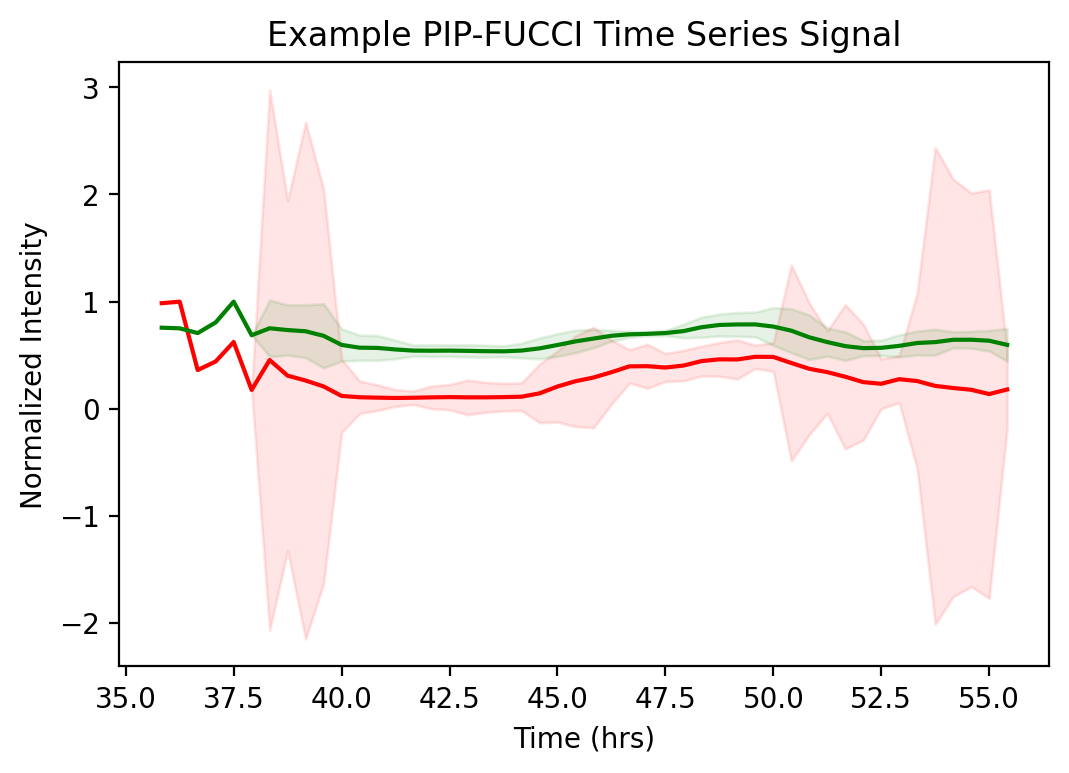

In [44]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

rand_tid = np.random.choice(df['TRACK_ID'], 1)[0]
print(rand_tid)

# rand_tid = 192

tmp = df[df['TRACK_ID'] == rand_tid].reset_index()

tmp['ub_red'] = tmp['mean_MEAN_INTENSITY_RED'] + tmp['std_MEAN_INTENSITY_RED']
tmp['lb_red'] = tmp['mean_MEAN_INTENSITY_RED'] - tmp['std_MEAN_INTENSITY_RED']

tmp['ub_green'] = tmp['mean_MEAN_INTENSITY_GREEN'] + tmp['std_MEAN_INTENSITY_GREEN']
tmp['lb_green'] = tmp['mean_MEAN_INTENSITY_GREEN'] - tmp['std_MEAN_INTENSITY_GREEN']


sns.lineplot(data=tmp,
             x='Time',
             y='mean_MEAN_INTENSITY_RED', 
             err_style='bars',
             color='r')


plt.fill_between(tmp['Time'], tmp['ub_red'], tmp['lb_red'], color='r', alpha=0.1)
plt.fill_between(tmp['Time'], tmp['ub_green'], tmp['lb_green'], color='g', alpha=0.1)

sns.lineplot(data=tmp,
             x='Time',
             y='mean_MEAN_INTENSITY_GREEN', 
             color='g')

plt.title(f"Example PIP-FUCCI Time Series Signal")
plt.xlabel("Time (hrs)")
plt.ylabel("Normalized Intensity")

In [49]:
df.columns

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED',
       'MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED',
       'STD_INTENSITY_RED', 'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN',
       'MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN',
       'STD_INTENSITY_GREEN', 'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE',
       'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE',
       'STD_INTENSITY_BLUE', 'CONTRAST_RED', 'SNR_RED', 'CONTRAST_GREEN',
       'SNR_GREEN', 'CONTRAST_BLUE', 'SNR_BLUE', 'ELLIPSE_X0', 'ELLIPSE_Y0',
       'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'STEP', 'Time', 'mean_MEAN_INTENSITY_RED', 'std_MEAN_INTENSITY_RED',
       'mean_MEAN_INTENSITY_GREEN', 'std_

Text(0, 0.5, 'SNR of Detected Nucleus')

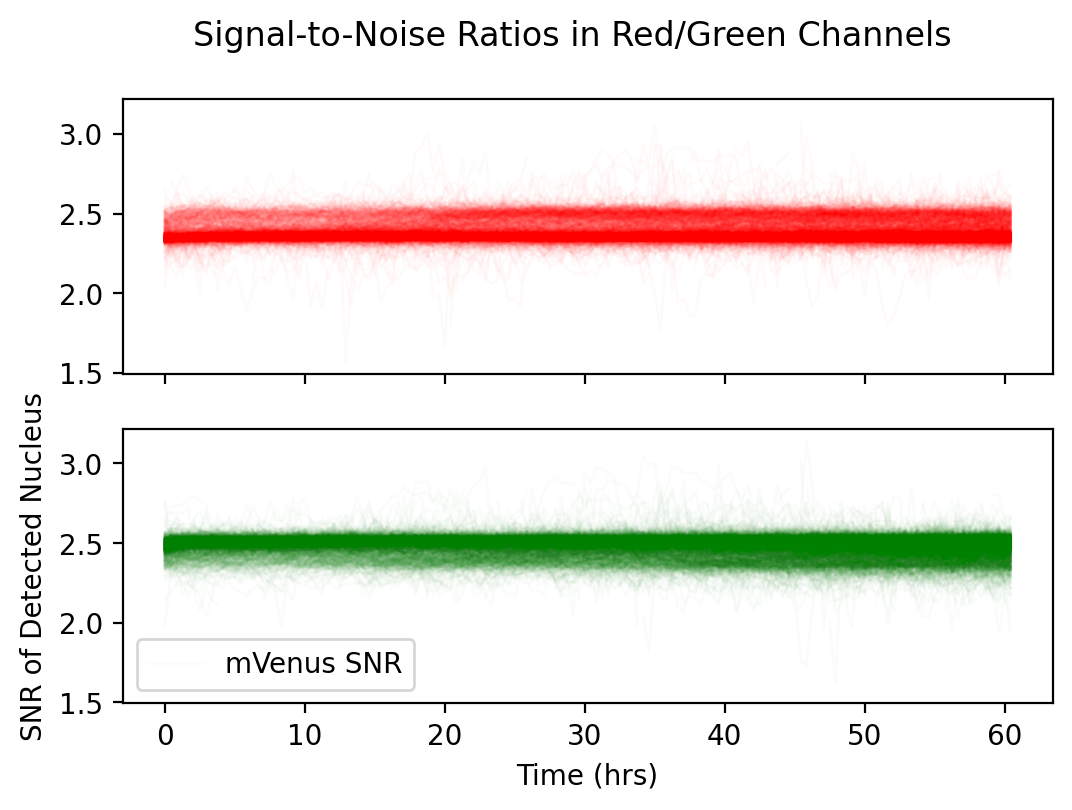

In [63]:
alpha=0.02

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

for i, t in enumerate(df['TRACK_ID'].unique()):
    tmp = df[df['TRACK_ID'] == t].reset_index().sort_values(by='FRAME')
    
    snr_red = np.log(tmp['SNR_RED'] + 10)
    snr_green = np.log(tmp['SNR_GREEN'] + 10)
    
    if i == 0:
        ax1.plot(tmp['Time'], snr_red, c='r', lw=1,alpha=alpha)
        ax2.plot(tmp['Time'], snr_green, c='g', lw=1,alpha=alpha)
    else:
        ax1.plot(tmp['Time'], snr_red, c='r', lw=1,alpha=alpha)
        ax2.plot(tmp['Time'], snr_green, c='g', lw=1,alpha=alpha)
        
        
plt.legend()
plt.suptitle(f"Signal-to-Noise Ratios in Red/Green Channels")
plt.xlabel("Time (hrs)")
plt.ylabel("SNR of Detected Nucleus")

# State Estimation

In [9]:
def simple_estimator(row, red, red_std, green, green_std):
    """A function to assign cell state to an individual cell using simple rules"""
    if row[green] >= row[red] + row[red_std]:
        return "G1"
    elif row[red] >= row[green] + row[green_std]:
        return "S"
    else:
        return "G2/M"
    
df['cycle_est_mean'] = df.apply(lambda row: simple_estimator(row, 
                                                               'mean_MEAN_INTENSITY_RED', 
                                                               'std_MEAN_INTENSITY_RED',
                                                               'mean_MEAN_INTENSITY_GREEN', 
                                                               'std_MEAN_INTENSITY_GREEN'), axis=1)
print(df['cycle_est_mean'].value_counts(dropna=False))
print()

G1      91227
G2/M    61872
S       61799
Name: cycle_est_mean, dtype: int64



In [10]:
transitions = {
    "G1" : "S",
    "S" : "G2/M",
    "G2/M" : "G1",
}


state_dfs = []

for tid in df['TRACK_ID'].unique():
    
    tmp = df[df['TRACK_ID'] == tid].sort_values(by=['TRACK_ID', 'FRAME'])
    
    states = tmp['cycle_est_mean'].to_list()
    
    for i, s in enumerate(states):
        if i > 0:
            prev_state = states[i - 1]
            curr_state = states[i]
            
            if not curr_state == transitions[prev_state]:
                states[i] = prev_state
                
    tmp['updated_guess'] = states
    
    state_dfs.append(tmp)

states = pd.concat(state_dfs, ignore_index=True)
print(states.shape)
states.head()

(211865, 56)


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,STEP,Time,mean_MEAN_INTENSITY_RED,std_MEAN_INTENSITY_RED,mean_MEAN_INTENSITY_GREEN,std_MEAN_INTENSITY_GREEN,mean_MEAN_INTENSITY_BLUE,std_MEAN_INTENSITY_BLUE,cycle_est_mean,updated_guess
0,ID2048,2048,0.0,0.881755,378.892277,1275.882220,0.0,0.000000,0,9.373108,...,0,0.000000,0.438156,0.0,0.607753,0.0,0.638965,0.0,G1,G1
1,ID3281,3281,0.0,0.840964,374.015596,1284.786984,0.0,1350.157432,1,8.524473,...,1,0.416667,0.757467,0.0,0.736921,0.0,0.742110,0.0,S,S
2,ID4242,4242,0.0,0.856497,370.306430,1287.541590,0.0,2700.314864,2,8.645886,...,2,0.833333,0.866712,0.0,0.728245,0.0,0.722111,0.0,S,S
3,ID5618,5618,0.0,0.809693,368.478977,1288.211695,0.0,4050.472296,3,7.301282,...,3,1.250000,0.833132,0.0,1.000000,0.0,1.000000,0.0,G1,S
4,ID6859,6859,0.0,0.790261,372.355090,1287.768018,0.0,5400.629728,4,7.889433,...,4,1.666667,0.738722,0.0,0.814599,0.0,0.802937,0.0,G1,S


Text(-3.0, 2, 'Initial')

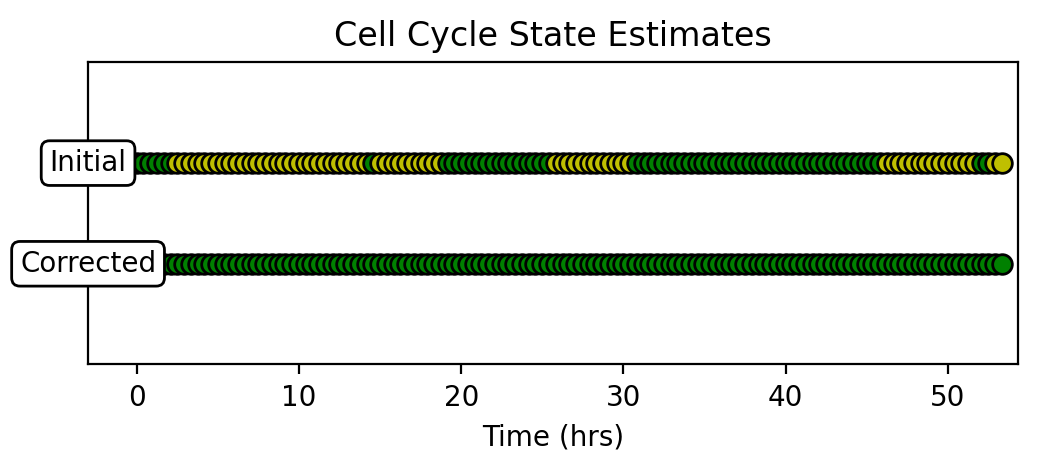

In [11]:
rand_tid = 192

tmp = states[states['TRACK_ID'] == rand_tid]
tmp = tmp.sort_values(by='FRAME').reset_index()

plt.rcParams['figure.figsize'] = 6, 2

for idx, row in tmp.iterrows():
    if row['cycle_est_mean'] == 'G1':
        plt.scatter(row['Time'], 2, s=50, c='g', edgecolor='k')
    elif row['cycle_est_mean'] == 'S':
            plt.scatter(row['Time'], 2, s=50, c='r', edgecolor='k')
    elif row['cycle_est_mean'] == 'G2/M':
        plt.scatter(row['Time'], 2, s=50, c='y', edgecolor='k')
        
        
    if row['updated_guess'] == 'G1':
        plt.scatter(row['Time'], 1, s=50, c='g', edgecolor='k')
    elif row['updated_guess'] == 'S':
        plt.scatter(row['Time'], 1, s=50, c='r', edgecolor='k')
    elif row['updated_guess'] == 'G2/M':
        plt.scatter(row['Time'], 1, s=50, c='y', edgecolor='k')
    
    
ax = plt.gca()
ax.set_ylim([0,3])
ax.axes.get_yaxis().set_visible(False)
plt.title(f"Cell Cycle State Estimates")
plt.xlabel("Time (hrs)")

min_t = tmp['Time'].min() - 3
max_t = tmp['Time'].max() + 1

ax.set_xlim([min_t,max_t])

ax.annotate("Corrected", xy=(min_t, 1), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"))

ax.annotate("Initial", xy=(min_t, 2), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"))

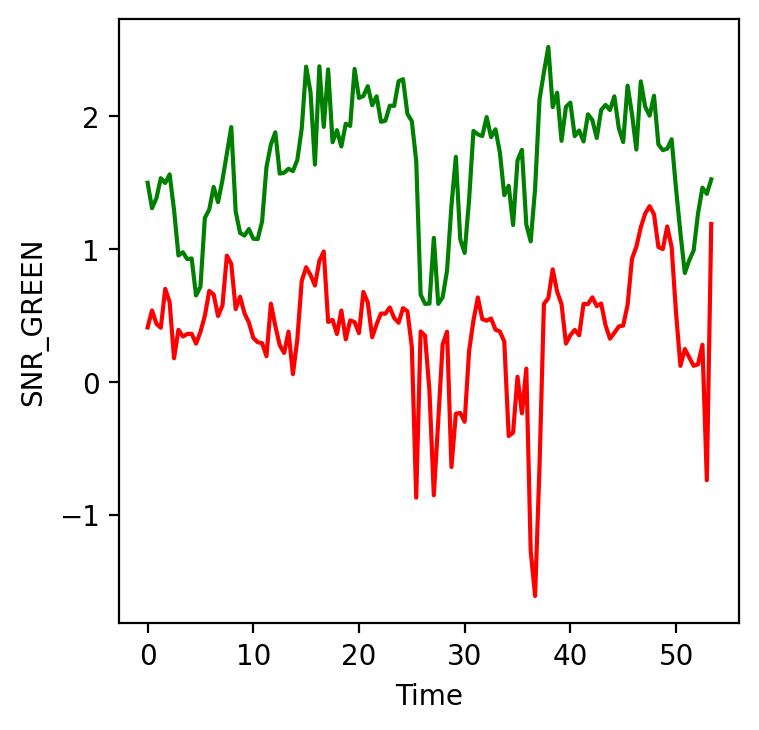

In [12]:
plt.rcParams['figure.figsize'] = 4, 4
sns.lineplot(data=tmp,
            x='Time',
            y='SNR_RED', 
            color='r')

sns.lineplot(data=tmp,
            x='Time',
            y='SNR_GREEN', 
            color='g')

In [13]:
g1 = pom.State(pom.DiscreteDistribution({'G1'  : 0.5, 
                                         'S'   : 0.25, 
                                         'G2/M': 0.25
                                        }), "G1")
s = pom.State(pom.DiscreteDistribution({'G1'  : 0.25,
                                        'S'   : 0.5, 
                                        'G2/M': 0.25
                                       }), "S")
g2 = pom.State(pom.DiscreteDistribution({'G1'  : 0.25, 
                                         'S'   : 0.25, 
                                         'G2/M': 0.5
                                        }), "G2")


model = pom.HiddenMarkovModel()
model.add_states(g1, s, g2)


model.add_transition(model.start, g1, 0.3333)
model.add_transition(model.start, s, 0.3333333)
model.add_transition(model.start, g2, 0.3333333)


model.add_transition(g1, g1, 0.79)
model.add_transition(g1, s , 0.19)
model.add_transition(g1, g2, 0.01)

model.add_transition(s,  s, 0.69)
model.add_transition(s, g2, 0.29)
model.add_transition(s, g1, 0.01)

model.add_transition(g2, g2, 0.69)
model.add_transition(g2, g1, 0.29)
model.add_transition(g2, s , 0.01)


model.bake()


seq = tmp['updated_guess'].to_numpy()
# hmm_predictions = model.fit(seq)
hmm_predictions = model.predict(seq, 'viterbi')

# print("sequence: {}".format(''.join(seq)))
# print("hmm pred: {}".format(''.join(map( str, hmm_predictions))))

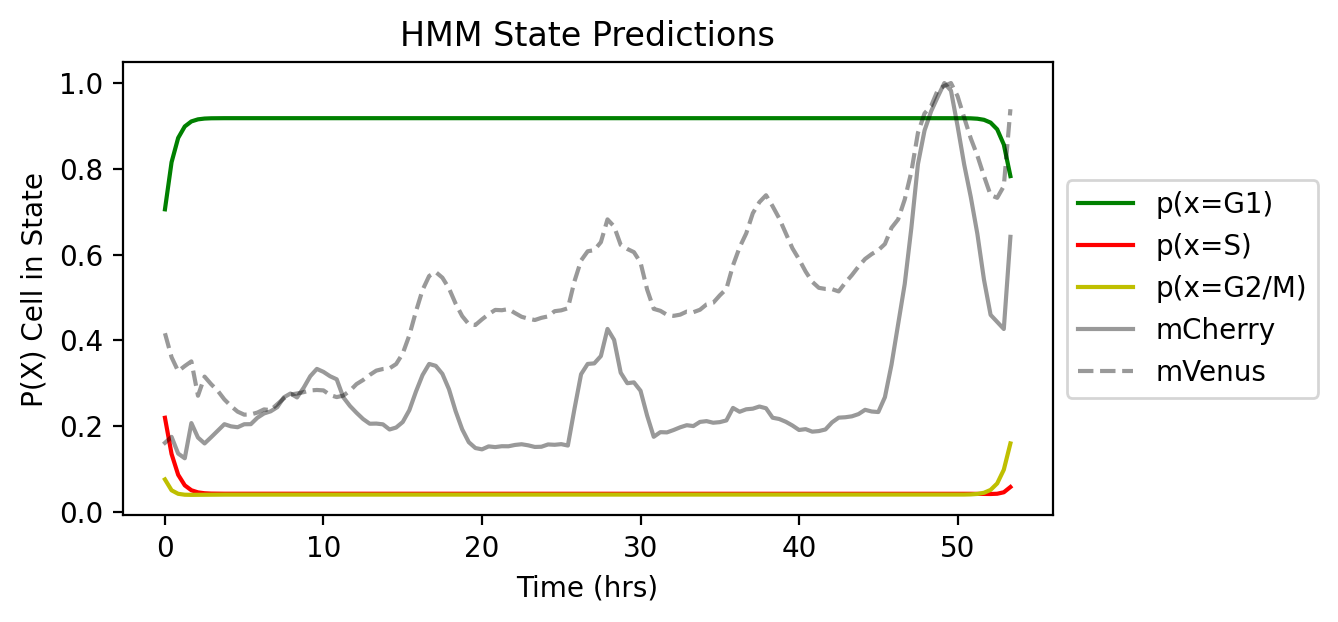

In [14]:

plt.rcParams['figure.figsize'] = 6, 3
test = pd.DataFrame(model.predict_proba(seq))
test.columns = ["G1", "S", "G2/M"]
test['Time'] = tmp['Time']

plt.plot(test['Time'], test['G1'], c='g', label='p(x=G1)')
plt.plot(test['Time'], test['S'], c='r', label='p(x=S)')
plt.plot(test['Time'], test['G2/M'], c='y', label='p(x=G2/M)')

plt.plot(tmp['Time'], tmp['mean_MEAN_INTENSITY_RED'], c='k', label='mCherry', alpha=0.4)
plt.plot(tmp['Time'], tmp['mean_MEAN_INTENSITY_GREEN'], c='k', ls="--", label='mVenus',  alpha=0.4)

plt.title(f"HMM State Predictions")
plt.xlabel("Time (hrs)")
plt.ylabel("P(X) Cell in State")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [15]:
tmp.columns

Index(['index', 'LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X',
       'POSITION_Y', 'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS',
       'VISIBILITY', 'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_RED',
       'MEDIAN_INTENSITY_RED', 'MIN_INTENSITY_RED', 'MAX_INTENSITY_RED',
       'TOTAL_INTENSITY_RED', 'STD_INTENSITY_RED', 'MEAN_INTENSITY_GREEN',
       'MEDIAN_INTENSITY_GREEN', 'MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN',
       'TOTAL_INTENSITY_GREEN', 'STD_INTENSITY_GREEN', 'MEAN_INTENSITY_BLUE',
       'MEDIAN_INTENSITY_BLUE', 'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE',
       'TOTAL_INTENSITY_BLUE', 'STD_INTENSITY_BLUE', 'CONTRAST_RED', 'SNR_RED',
       'CONTRAST_GREEN', 'SNR_GREEN', 'CONTRAST_BLUE', 'SNR_BLUE',
       'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR',
       'ELLIPSE_THETA', 'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER',
       'CIRCULARITY', 'SOLIDITY', 'STEP', 'Time', 'mean_MEAN_INTENSITY_RED',
       'std_MEAN_INTENSITY_RED', 'mean_MEAN_INTENSITY_GREE

In [18]:
# break

In [19]:
print(len(states))

y = pd.get_dummies(states['updated_guess'])
states = states.join(y)

print(len(states))
states.head()

211865
211865


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,std_MEAN_INTENSITY_RED,mean_MEAN_INTENSITY_GREEN,std_MEAN_INTENSITY_GREEN,mean_MEAN_INTENSITY_BLUE,std_MEAN_INTENSITY_BLUE,cycle_est_mean,updated_guess,G1,G2/M,S
0,ID2048,2048,0.0,0.881755,378.892277,1275.882220,0.0,0.000000,0,9.373108,...,0.0,0.607753,0.0,0.638965,0.0,G1,G1,1,0,0
1,ID3281,3281,0.0,0.840964,374.015596,1284.786984,0.0,1350.157432,1,8.524473,...,0.0,0.736921,0.0,0.742110,0.0,S,S,0,0,1
2,ID4242,4242,0.0,0.856497,370.306430,1287.541590,0.0,2700.314864,2,8.645886,...,0.0,0.728245,0.0,0.722111,0.0,S,S,0,0,1
3,ID5618,5618,0.0,0.809693,368.478977,1288.211695,0.0,4050.472296,3,7.301282,...,0.0,1.000000,0.0,1.000000,0.0,G1,S,0,0,1
4,ID6859,6859,0.0,0.790261,372.355090,1287.768018,0.0,5400.629728,4,7.889433,...,0.0,0.814599,0.0,0.802937,0.0,G1,S,0,0,1


In [20]:
grped = states.groupby(['Time']).agg(
    sum_G1 = ('G1', np.sum),
    sum_S = ('S', np.sum),
    sum_G2 = ('G2/M', np.sum),
).reset_index()


grped.head()

,Time,sum_G1,sum_S,sum_G2
0,0.000000,711.0,261.0,0.0
1,0.416667,627.0,400.0,0.0
2,0.833333,560.0,484.0,0.0
3,1.250000,503.0,550.0,0.0
4,1.666667,448.0,602.0,0.0


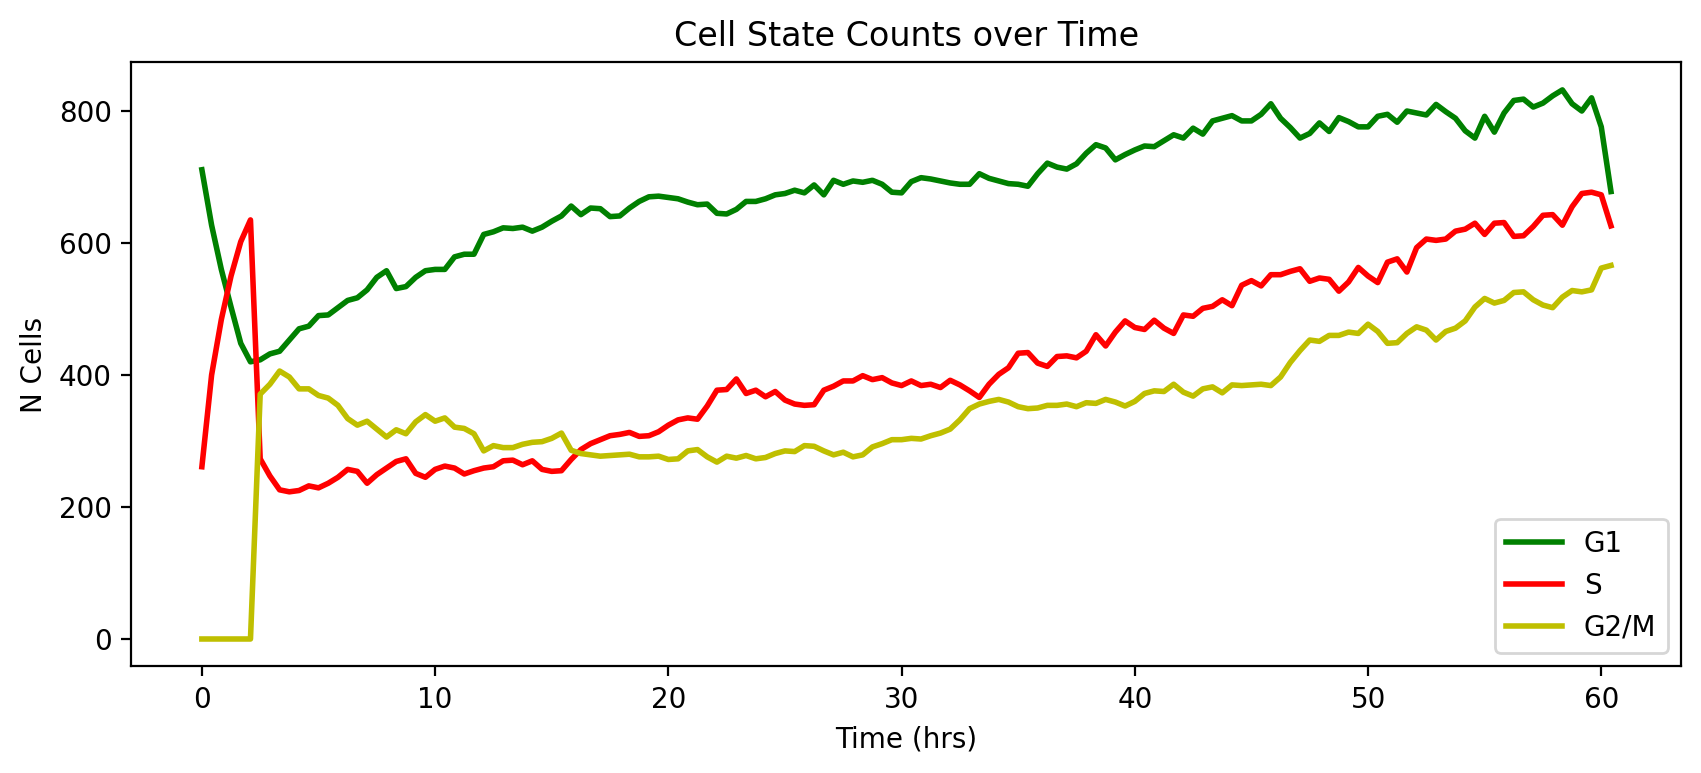

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 4

"""
CONTROL
"""

plt.plot(grped['Time'], 
               grped['sum_G1'], 
               label='G1', 
               c='g', 
               lw=2)


plt.plot(grped['Time'], 
               grped['sum_S'], 
               label='S', 
               c='r', 
               lw=2)


plt.plot(grped['Time'], 
               grped['sum_G2'], 
               label='G2/M', 
               c='y', 
               lw=2)

plt.title("Cell State Counts over Time")
plt.ylabel("N Cells")
plt.xlabel("Time (hrs)")
plt.legend()

(419.09951987652624, 670.3682070154174, 750.3548294164347, 1039.201955856729)

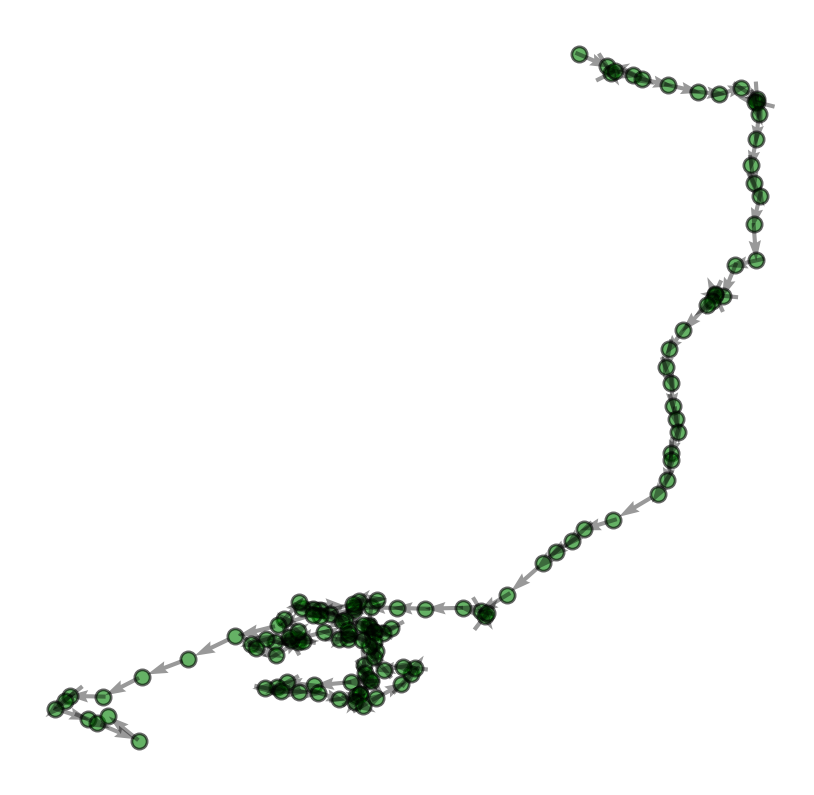

In [22]:
# rid = np.random.choice(states['TRACK_ID'], 1)[0]

tmp = states[states['TRACK_ID'] == rand_tid]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5,5

alpha = 0.6
arrow_alpha=0.4
size = 30


for phase in tmp['updated_guess'].unique():
    st_tmp = tmp[tmp['updated_guess'] == phase]

    if phase == 'G1':
        plt.scatter(st_tmp['POSITION_X'], st_tmp['POSITION_Y'], s=size, c='g', edgecolor='k', alpha=alpha)

    if phase == 'S':
        plt.scatter(st_tmp['POSITION_X'], st_tmp['POSITION_Y'], s=size, c='r', edgecolor='k', alpha=alpha)

    if phase == 'G2/M':
        plt.scatter(st_tmp['POSITION_X'], st_tmp['POSITION_Y'], s=size, c='y', edgecolor='k', alpha=alpha)
        
x = tmp['POSITION_X'].values
y = tmp['POSITION_Y'].values

u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2
norm = np.sqrt(u**2+v**2)   

plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", alpha=arrow_alpha)
# plt.title("Spatial Cell Cycle Estimates in Time") 
plt.axis(False)

In [23]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 14, 18

alpha = 0.4

grped['total'] = grped['sum_G1'] + grped['sum_S'] + grped['sum_G2']

grped['sum_G1_prop'] = grped['sum_G1'] / grped['total']
grped['sum_S_prop'] = grped['sum_S'] / grped['total']
grped['sum_G2_prop'] = grped['sum_G2'] / grped['total']

grped.head()


# plt.bar(grped['Time'], grped['sum_G1_prop'], color='g', label='G1', alpha=alpha, width=0.3)
# plt.bar(grped['Time'], grped['sum_S_prop'],  color='r', bottom=grped['sum_G1_prop'], label='S', alpha=alpha)
# plt.bar(grped['Time'], grped['sum_G2_prop'],  color='y', bottom=grped['sum_G1_prop'] + grped['sum_S_prop'], label='G2/M', alpha=alpha)

# plt.title(f"Cells in Each Phase of the Cell Cycle")
# plt.ylabel("Proportion of Total Cells")
# plt.xlabel("Time (hrs)")
# plt.legend(loc="upper right")

,Time,sum_G1,sum_S,sum_G2,total,sum_G1_prop,sum_S_prop,sum_G2_prop
0,0.000000,711.0,261.0,0.0,972.0,0.731481,0.268519,0.0
1,0.416667,627.0,400.0,0.0,1027.0,0.610516,0.389484,0.0
2,0.833333,560.0,484.0,0.0,1044.0,0.536398,0.463602,0.0
3,1.250000,503.0,550.0,0.0,1053.0,0.477683,0.522317,0.0
4,1.666667,448.0,602.0,0.0,1050.0,0.426667,0.573333,0.0
